「PyTorchモデルのONNXへの変換とONNXランタイムでの実行」
======================================
【原題】(OPTIONAL) EXPORTING A MODEL FROM PYTORCH TO ONNX AND RUNNING IT USING ONNX RUNTIME

【原著者】記載なし

【元URL】https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　小川 雄太郎

【日付】2020年10月28日

【チュトーリアル概要】

本チュートリアルでは、PyTorchで構築したモデルを、ONNXランタイムで使用できるモデルへと変換する方法、そして、ONXXランタイムでモデルを実行する方法について解説します。

---

ONNXへの変換と実行
=====

本チュートリアルでは、PyTorchで定義したモデルをONNX形式に変換し、ONNX Runtimeで実行する手法について解説します。

<br>

ONNX Runtimeは、ONNXモデルの実行に特化したエンジンであり、複数のプラットフォームやハードウェアに対応しており、効率的に推論を行うことができます
（Windows、Linux、Macなどに対応。そしてCPUとGPUの両方にも対応しています）。

ONNXランタイムは、複数のモデルでパフォーマンスを大幅に向上させることが証明されています（[参考](https://cloudblogs.microsoft.com/opensource/2019/05/22/onnx-runtime-machine-learning-inferencing-0-4-release)）。





本チュートリアルでは、[ONNX](https://github.com/onnx/onnx)と[ONNX Runtime](https://github.com/microsoft/onnxruntime)をインストールしておく必要があります。

ONNX と ONNX Runtime のバイナリビルドは、

``pip install onnx onnxruntime``

でインストールできます（Python3.5から3.7に対応しています）。

<br>

``注意``:

本チュートリアルを実行するには、PyTorchのマスターブランチが必要です。

以下の指示にしたがってください（[こちら](https://github.com/pytorch/pytorch#from-source)）。





In [1]:
%matplotlib inline

In [2]:
# Some standard imports
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

超解像（Super-resolution）とは、画像や動画の解像度を上げる方法です。

画像処理や動画編集などで広く使われています。

本チュートリアルでは、サイズの小さな、超解像モデルを使用します。

まずはPyTorchで、SuperResolutionモデルを構築してみましょう。




今回構築するモデルは、画像の解像度をアップスケールファクターを用いて詳細にするために、以下の論文で使われている、効率的なサブピクセル畳み込み層を使用します。

["Real-Time Single Image and Video Super-Resolution Using an Efficient
Sub-Pixel Convolutional Neural Network" - Shi et al](https://arxiv.org/abs/1609.05158)

<br>

このモデルは、画像のYCbCrのY成分を入力とし、超解像度でアップスケールしたY成分を出力します。

（日本語訳注：YCBCRは色空間の一種です）

モデルはPyTorchのモデルサンプルから、直接、変更の必要なく取得して使用できます（[モデルはこちら](https://github.com/pytorch/examples/blob/master/super_resolution/model.py)）。



In [3]:
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init


class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

通常ではこのモデルに対して訓練を実施しますが、本チュートリアルでは代わりに訓練済みの重みをダウンロードして使用します。

ただし、このダウンロードモデルは完全に精度を高めるレベルまでは訓練されておらず、チュートリアル用に使用するものである点にご注意ください。

<br>

``torch_model.eval()``、もしくは、 ``torch_model.train(False)``を実行し、モデルを推論モードにしておく必要があります。

この切り替えは、dropout や batchnorm などのモジュールが、推論モードと訓練モードで挙動が異なるために必要となります。

In [4]:
# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()

Downloading: "https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth" to /root/.cache/torch/hub/checkpoints/superres_epoch100-44c6958e.pth


SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

PyTorchでモデルをエクスポートするには、traceまたはscriptを使用します。

本チュートリアルでは、traceによってエクスポートする例を紹介します。

<br>

モデルをエクスポートするには ``torch.onnx.export()`` 関数を呼び出します。

これはモデルを実行し、出力を計算する間に、どの演算子が使用されたのかをtraceとして記録します。

`export()`はモデルを実行するので、入力テンソル``x``を与える必要があります。

入力テンソル``x``は、型と形さえ正確であれば、値はランダムで構いません。




入力データのサイズは、動的軸（dynamic axes）として指定されていない限り、エクスポートされたONNXグラフでは、入力データのサイズ（形）が固定される点に注意してください。

本チュートリアルでは、バッチサイズ1の入力でモデルをエクスポートしますが、torch.onnx.export()``の ``dynamic_axes`` パラメータで、1次元目を動的に指定することとします（日本語訳注：1次元目は通常、ミニバッチサイズなので、変わることが多いため）。






したがって、エクスポートされたモデルは、サイズ  [batch_size, 1, 224, 224] の入力を想定することとなります。

PyTorch のエクスポートインターフェイスについて、さらなる詳細は、[torch.onnxドキュメント](https://pytorch.org/docs/master/onnx.html)をご覧ください。

In [6]:
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # 対象モデル
                  x,                         # 入力サンプル
                  "super_resolution.onnx",   # 保存先
                  export_params=True,        # モデルファイルに訓練した重みを保存するかどうか
                  opset_version=10,          # ONNXのバージョン
                  do_constant_folding=True,  # constant folding for optimizationを実施するかどうか
                  input_names = ['input'],   # モデルへの入力変数名
                  output_names = ['output'], # モデルの出力変数名
                  dynamic_axes={'input' : {0 : 'batch_size'},    # 動的軸（dynamic axes）の指定
                                'output' : {0 : 'batch_size'}})

上記の実装で、モデルの出力 ``torch_out``を計算しています。

この計算結果は、後ほどエクスポートしたモデルをONNX Runtimeで実行したときに、同じ値が得られるのか確認する際に使用します．




ONNX Runtimeでモデルの出力を検証する前に、ONNXのAPIでONNXのAPI（関数）を確認します。

まず、``onnx.load("super_resolution.onnx")``は保存されたモデルを読み込み、onnx.ModelProto構造体（MLモデルを束ねるための最上位のファイル/コンテナのフォーマット）を出力します。

より詳細については、[onnx.protoドキュメント](<https://github.com/onnx/onnx/blob/master/onnx/onnx.proto)をご覧ください。

<br>

``onnx.checker.check_model(onnx_model)``はモデルの構造をチェックし、定められたスキームに準拠しているかを確かめます。

ONNXグラフの妥当性は、モデルのバージョン、グラフの構造、ノードとその入出力を確認して検証されます。




In [7]:
# 日本語訳注：追記
!pip install onnx onnxruntime

     |████████████████████████████████| 7.7MB 7.6MB/s 
     |████████████████████████████████| 4.1MB 49.7MB/s 


In [8]:
import onnx

onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

それでは、ONNX RuntimeのPython APIを使って出力を計算してみましょう。

<br>

この計算部分は通常は、別のプロセスや別のマシンで行うことになりますが、ONNX RuntimeとPyTorchが、今回のネットワークに対して同じ値の計算となることを確認できるように、同じNotebook内で本チュートリアルを進めていきます。




ONNX Runtimeを使用してモデルを実行するには、選択したconfigparametersを使用して、モデルの推論セッションを作成する必要があります（今回はデフォルトのconfigを使用しています）。


セッションが作成できれば、run() apiを使ってモデルを計算します。

以下の実行結果は、ONNX Runtimeによって計算されたモデルの出力のリストです。




In [14]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# ONNX Runtimeで推論
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# ONNX Runtime と PyTorch の結果を比較
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")


# 日本語訳追記
print("----------")
print(to_numpy(torch_out))
print("----------")
print(ort_outs[0])


Exported model has been tested with ONNXRuntime, and the result looks good!
----------
[[[[ 0.19460359  0.21037234  0.11826501 ...  0.06353676  0.14260483
     0.06016565]
   [ 0.28914338  0.34920377  0.22157417 ...  0.18678327  0.20302399
     0.09842675]
   [ 0.3430441   0.39534667  0.24607483 ...  0.2529284   0.06464601
    -0.099323  ]
   ...
   [ 0.8320258   0.76533544  0.46196407 ...  0.75551736  0.6576302
     0.46637756]
   [ 0.7019327   0.54509085  0.32078204 ...  0.5048112   0.26509532
     0.2175103 ]
   [ 0.49331537  0.35996222  0.18505673 ...  0.2110489   0.15199183
     0.19403595]]]]
----------
[[[[ 0.19460359  0.21037236  0.11826503 ...  0.06353696  0.14260502
     0.06016574]
   [ 0.2891434   0.3492038   0.22157428 ...  0.18678355  0.20302421
     0.09842682]
   [ 0.3430441   0.39534658  0.24607483 ...  0.25292856  0.06464611
    -0.099323  ]
   ...
   [ 0.832026    0.76533526  0.46196398 ...  0.75551754  0.6576304
     0.4663774 ]
   [ 0.70193267  0.54509073  0.320782

PyTorch と ONNX Runtime の出力が、与えられた精度（rtol=1e-03 と atol=1e-05）で数値的に一致していることが確認できました。


もし、一致しない場合は、ONNX exporterに問題があると思われますので、その場合はPyTorchOrgまでお問い合わせください。




ONNXランタイムでの画像入力
=====




以上までで、PyTorchからモデルをエクスポートし、ダミーテンソルを入力としてONNXランタイムでロードして実行する方法を紹介しました。



続いて、本チュートリアルでは、広く使われている有名な猫の画像を使用します。

cat_224x224.jpg




In [15]:
# 日本語版注：追記

from google.colab import files
uploaded = files.upload()
# cat_224x224.jpgをアップロードしてください。
# https://github.com/YutaroOgawa/pytorch_tutorials_jp/tree/main/assets に画像を置いています


Saving cat_224x224.jpg to cat_224x224.jpg


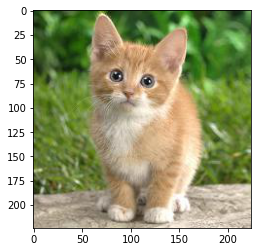

In [16]:
# 読み込んだ画像の表示

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img = Image.open("cat_224x224.jpg")
plt.imshow(img)
plt.show()


まず、画像を読み込み、Pythonの標準ライブラリPILを使って前処理を行います。

<br>

これから実施する前処理は、ニューラルネットワークの訓練/テストのデータ処理では標準的な手続きとなります。

<br>

まず所望の入力サイズ（224x224）に合わせるように、画像をリサイズします。

次に画像をY、Cb、Crの各成分に分割します。

これらの色成分は、グレースケール画像（Y）と、青差（Cb）と赤差（Cr）の彩度成分を表しています。

Y成分が人間の目に対してはより敏感に影響するので、このように変換した要素の成分に着目します。


Y成分を抽出した後、モデルの入力となるテンソルに変換します。




In [17]:
from PIL import Image
import torchvision.transforms as transforms

# img = Image.open("./_static/img/cat.jpg")

# 日本語訳注：Google Colabに合わせて変更
img  =  Image.open("cat_224x224.jpg")

resize = transforms.Resize([224, 224])
img = resize(img)

img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img_y)
img_y.unsqueeze_(0)

tensor([[[[0.2157, 0.1961, 0.1922,  ..., 0.5294, 0.5569, 0.5725],
          [0.2039, 0.1922, 0.1922,  ..., 0.5333, 0.5529, 0.5686],
          [0.2000, 0.1843, 0.1843,  ..., 0.5216, 0.5373, 0.5490],
          ...,
          [0.6667, 0.6745, 0.6392,  ..., 0.6902, 0.6667, 0.6078],
          [0.6392, 0.6431, 0.6235,  ..., 0.8000, 0.7608, 0.6745],
          [0.6392, 0.6353, 0.6510,  ..., 0.8118, 0.7686, 0.6667]]]])

In [18]:
# 日本語訳注：追記、テンソルの形の確認
img_y.shape

torch.Size([1, 1, 224, 224])

それでは続いて、このグレースケールにリサイズされた猫画像を表すテンソルを、本チュートリアルの前半で説明した、超解像モデルに与え、ONNX Runtimeで実行してみましょう。




In [19]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

この時点で、モデルの出力はテンソルとなっています。


最後にモデルの出力を処理し、出力テンソルから最終的な出力画像を構築して、画像を保存します。


後処理の手順は、超解像モデルのPyTorch実装から採用しています（[詳細はこちら](https://github.com/pytorch/examples/blob/master/super_resolution/super_resolve.py)）。



In [20]:
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")

# Save the image, we will compare this with the output image from mobile device
# final_img.save("./_static/img/cat_superres_with_ort.jpg")

# 日本語訳注：上記のfinal_imag.saveの行は、コメントアウトしています


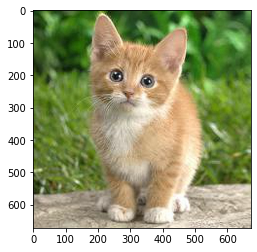

In [22]:
# 日本語訳注：表示
# 画像のサイズが最初の224×224よりも、大きくなっている（超解像度された）ことが分かります。

plt.imshow(final_img)
plt.show()

In [23]:
# 日本語訳注：Google Colabでの保存
from google.colab import files

final_img.save("cat_superres_with_ort.jpg")
files.download('cat_superres_with_ort.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ONNXランタイムはクロスプラットフォームエンジンであるため、複数のプラットフォームにまたがって、CPUとGPUの両方で実行することができます。

<br>

またONNXランタイムは、Azure Machine Learning Servicesのモデル推論用に、クラウドにデプロイすることも可能です。

Azure MLサービスの詳細はについては、[こちら](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-onnx)をご覧ください。


ONNX Runtimeのパフォーマンス情報については、[こちら](https://github.com/microsoft/onnxruntime#high-performance)をご覧ください。

また、その他、ONNX Runtimeについての詳細情報は、[こちら](https://github.com/microsoft/onnxruntime)をご覧ください。


